# Plus Problem 1

This is a legitimate machine learning mini-project that ties together several ideas, so it it worth 16 plus points.

The file http://cse151a.com/data/yelp/train.csv contains 10,000 Yelp reviews along with the score the user left (from 1 to 5, with 5 being best).  In this plus problem, you'll train an SVM to do sentiment analysis on these reviews and predict the sentiment of an unlabeled piece of text.

a) Split the data 75%/25% into training and validation sets, encode teh training data using a bag of words feature representation, and train a (linear, soft-margin) support vector machine.  When training, consider any review with a score of 4 or higher to be a positive review, and anything with a smaller score to be a negative review.  Find the value of $C$ that minimizes the error of your classifier on the validation set and make a plot of the validation error as a function of $C$.

  For this part, turn in four things:
  1. The value of $C$ that was best,
  1. the training and validation error that corresponded to this choice of $C$,
  1. your plot, and
  1. your code
  
You can use whatever machine learning libraries you like in whatever language you'd like.  Note that most languages have libraries which will do the bag-of-words encoding for you.  For instance, `sklearn` has this feature (but I'll let you Google for it!).

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./train.csv")

Using sklearn's train_test_split to randomly split our data into training and validation sets.  We're doing this before setting up our bag of words since we only want to build our dictionary using the trainig set.

In [3]:
# Create boolean class "Positive?"
data["Positive"] = data.Rating >= 4

In [4]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(data, train_size=0.75)

We'll use sklearn's CountVectorizer to quickly make bag-of-words encodings.  Each review will be encoded as a vector with length corresponding to a dictionary and entries as the number of occurrences of each word in the dictionary.

Since there are likely to be words that show up very few times in reviews, and thus aren't able to be learned from, it makes sense to cap our dictionary size to only the $k$ most frequently occurring words across all of our reviews.  The value of $k$ can be played with, but as the dictionary gets too large training becomes more expensive and the added terms are unlikely to carry much power.

There are likely to be words which show up very commonly but act merely as syntactical structure, and don't carry much meaning, such as *"the, and, a, to, of, ..."*.  These are considered 'stop-words', and can often be removed from our encodings to improve the model performance.

See the [CountVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [5]:
# Engineer the bag-of-words using sklearn's CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_features=10_000)

In [6]:
vectorizer.fit(train.Review)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [7]:
# This returns a sparse matrix!  If we want to work with it easily (though
# at the cost of memory), we can cast it to a numpy array.
X_train = vectorizer.transform(train.Review).toarray()
X_valid = vectorizer.transform(valid.Review).toarray()

In [8]:
y_train = train.Positive
y_valid = valid.Positive

Using `LinearSVC` from sklearn since it's better optimized for the linear case!  See [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) and [Campuswire post #656](https://campuswire.com/c/GD09972CF/feed) for more explanation.

In [9]:
from sklearn.svm import LinearSVC

# Starting with a default value of C.  We'll play with this later.
clf = LinearSVC(C=1.0)

In [10]:
clf.fit(X_train, y_train)

print(f"Training error:   {1 - clf.score(X_train, y_train):>6.2%}")
print(f"Validation error: {1 - clf.score(X_valid, y_valid):>6.2%}")

Training error:    0.15%
Validation error: 20.76%


Now we use the validation set to tune our hyperparameter $C$.

In [11]:
%%time

# How'd I choose these?  I ran from 1e-3 to 1e3 as seen in lecture, but
# I noticed a sharp spike near my low-end, so I shifted this and ran
# from 1e-5 to 1e0.  This gave me a nice range to look at, so I boosted
# the granularity.
C_values = 10**np.arange(-3.0, 3.0)
C_values = 10**np.arange(-5.0, 0.0)
C_values = 10**np.arange(-5.0, 0.0, 0.5)

train_scores = []
valid_scores = []

for C in C_values:
    
    clf = LinearSVC(C=C)
    clf.fit(X_train, y_train)
    
    train_scores.append(1 - clf.score(X_train, y_train))
    valid_scores.append(1 - clf.score(X_valid, y_valid))


CPU times: user 9.75 s, sys: 16.7 s, total: 26.5 s
Wall time: 16.9 s


In [12]:
# This should look similar to lecture
pd.DataFrame({"C": C_values, "Train Error": train_scores, "Validation Error": valid_scores})

,C,Train Error,Validation Error
0,0.000010,0.381733,0.4028
1,0.000032,0.320667,0.3388
2,0.000100,0.235067,0.2588
3,0.000316,0.183333,0.2112
4,0.001000,0.144133,0.1776
5,0.003162,0.102533,0.1632
6,0.010000,0.062933,0.1600
7,0.031623,0.031467,0.1684
8,0.100000,0.012267,0.1800
9,0.316228,0.004267,0.1960


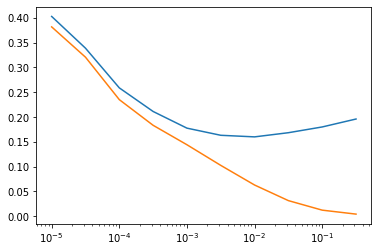

In [13]:
plt.plot(C_values, valid_scores)
plt.plot(C_values, train_scores)
plt.xscale("log")

In [14]:
best_val_idx = np.argmin(valid_scores)
best_val_valid   = valid_scores[best_val_idx]
best_val_train   = train_scores[best_val_idx]
best_val_C       = C_values[best_val_idx]

print(f"Best C on validation set is roughly C={best_val_C} with "
      f"training error of {best_val_train:.2%} and "
      f"validation error of {best_val_valid:.2%}")

Best C on validation set is roughly C=0.01 with training error of 6.29% and validation error of 16.00%


After that value of $C$ our validation error starts climbing again.  Notice what's happening with our training error though...

b) Is the data in `train.csv` linearly separable?  How do you know?

There's a chance that with such high dimensionality, our data is linearly separable.  Let's uncap our dictionary and leave in stop words so that we're not reducing the dimensionality.

If we take out all the slack from an SVM, we can check for linear separability.

While it's enough to show that our data isn't linearly separable by showing that a subset isn't linearly separable, we're going to need to check the entire dataset if we want to prove that the dataset *is* linearly separable.

In [15]:
vectorizer_all = CountVectorizer(stop_words=None, max_features=None)

X_all = vectorizer_all.fit_transform(data.Review)
y_all = data.Positive


# To avoid any slack, we must place a huge penalty on it!
C_all = 10e9

# To see if we eventually converge, let's increase our cap on iterations
clf_all = LinearSVC(C=C_all, max_iter=10e6)
clf_all.fit(X_all, y_all)

end_score = 1 - clf_all.score(X_all, y_all)

if end_score == 0:
    print("Converged ==> Linearly Separable!")
else:
    print("Didn't converge ==> Not linearly separable.")

Converged ==> Linearly Separable!


c) Give an example of:
  - A sentence that you think is positive that your predictor got right.
  - A sentence that you think is negative that your predictor got right.
  - A sentence that you think is positive that your predictor got wrong.

In [16]:
# Let's reinstantiate our best validation-set classifier and experiment!
clf = LinearSVC(C=best_val_C)

clf.fit(X_train, y_train)

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [17]:
def predict(sentence):
    
    X_sentence = vectorizer.transform([sentence])
    
    return clf.predict(X_sentence)

In [18]:
predict("Excellent service, as always.")
# Expect Positive

array([ True])

In [19]:
predict("That was terrible, made my stomach hurt.")
# Expect Negative

array([False])

In [20]:
most_negative_idx = clf.coef_.argsort()[:,:10]
most_negative_words = np.array(list(vectorizer.vocabulary_))[most_negative_idx]
most_negative_words

array([['canceled', 'primanti', 'xl', 'workouts', 'patio', 'breads',
        'pillow', 'struggling', 'waived', 'jackets']], dtype='<U22')

Can we abuse the "most negative" words?

In [27]:
predict("They gave us a free pillow!")

array([False])